# Predicting Quantum State Propagation Through Time

In this example, we will predict the time evolution of quantum states given a particular initial wavefunction $\psi(\vec x, 0)$ and the governing Hamiltonian $\hat H$. We will do so by using an ESN to predict the solutions of the time-dependent Schrodinger Equation $$i\hbar \frac{\partial }{\partial t} \psi(\vec x, t) = \hat H\psi (\vec x, t)$$ which governs the evolution of the wavefunction of a non-relativistic quantum system.

# Example PDE

## Definition
We will define our Hamiltonian $\hat H$ as follows $$\hat H = \hat T + \hat V = -\frac12 \nabla^2 + V(\vec x)$$ i.e. a time-independent Hamiltonian in 2D.
We will approximate the time evolution operator over a small interval of time as $$\psi(t + \delta t) \approx e^{-i\hat H \delta t}\psi(t) \approx e^{-\hat V\delta t /2}e^{-i\hat T \delta t}e^{-i\hat V \delta t/2}\psi(t)$$ Our starting wavefunction $\psi(\vec x, 0)$ will be a 2D Gaussian wave packet ($\sigma = 1$) with some momentum in the x-direction.
$$\psi(\vec x, 0) = e^{-\frac{|{\vec x}|}{2\sigma^2}}e^{ik_0x}$$

## Split Operator Fourier Method
We'll use the split operator method to solve the PDE. This will involve using position space for the potential energy component, and momentum space (with FFTs) for the kinetic component.

In [2]:
import numpy as np

def solve_tdse_2d(t=100, sigma=1.0, k0=1.0, omega=1.0, snapshot_every=1, N=32):
    # Grid Definitions
    L = 10.0
    dx = L / N
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    X, Y = np.meshgrid(x, x, indexing='ij')

    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    KX, KY = np.meshgrid(kx, kx, indexing='ij')
    K2 = KX**2 + KY**2

    psi = np.exp(-(X**2 + Y**2) / (2 * sigma**2)) * np.exp(1j * k0 * X)
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx**2)

    V = 0.5 * omega**2 * (X**2 + Y**2)

    dt = 0.01
    n_steps = t
    V_half = np.exp(-0.5j * V * dt)
    T_full = np.exp(-1j * K2 * dt)

    n_snapshots = t // snapshot_every
    wavefunctions = np.zeros((n_snapshots, N, N), dtype=np.complex64)

    for step in range(n_steps):
        psi = V_half * psi
        psi_k = np.fft.fft2(psi)
        psi_k *= T_full
        psi = np.fft.ifft2(psi_k)
        psi = V_half * psi

        psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx**2)

        if step % snapshot_every == 0:
            wavefunctions[step // snapshot_every] = psi

    return wavefunctions

T = 2500 
N = 32 
HORIZON=100

# Run simulation
psis = solve_tdse_2d(t=T, N=N)
np.savez_compressed('wavefunctions.npz', psis=psis)

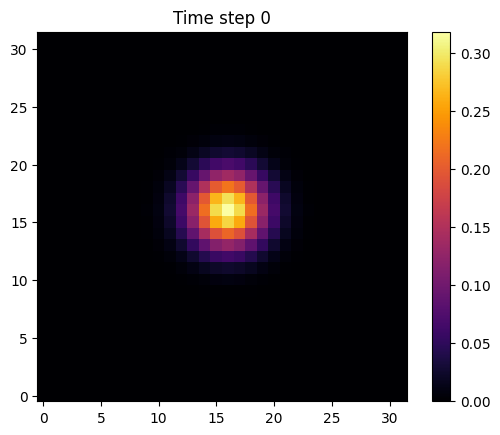

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100  # For inline playback in notebooks

psis = np.load('wavefunctions.npz')['psis']

# Set up plot
fig, ax = plt.subplots()
initial_density = np.abs(psis[0])**2
im = ax.imshow(initial_density, cmap='inferno', origin='lower', vmin=0, vmax=np.max(initial_density))
fig.colorbar(im)
ax.set_title("Time step 0")

def update(frame):
    density = np.abs(psis[frame])**2
    im.set_data(density)
    ax.set_title(f"Time step {frame}")
    return [im]


ani = animation.FuncAnimation(
    fig, update, frames=T, interval=50, repeat=False
)

# Save or display animation
ani.save("quantum_evolution.mp4", fps=30, dpi=150)


Let's set up some hyperparameter optimization!

In [4]:
import numpy as np 

from aqua_blue_hyperopt.hyper import ModelParams, Optimizer, Algo, default_loss

import numpy as np 

from aqua_blue.time_series import TimeSeries
from aqua_blue.models import Model
from aqua_blue.reservoirs import DynamicalReservoir
from aqua_blue.readouts import LinearReadout
from aqua_blue.utilities import Normalizer

wavefunctions = np.load('wavefunctions.npz')['psis']
wavefunctions = wavefunctions.reshape(T, -1)
t = np.arange(T)

TEST_DATA = wavefunctions[T-HORIZON:]
TRAIN_DATA = wavefunctions[:T-HORIZON]

# Get probability amplitudes
TEST_DATA = np.abs(TEST_DATA)**2 
TRAIN_DATA = np.abs(TRAIN_DATA)**2

TEST_T = t[T-HORIZON:]
TRAIN_T = t[:T-HORIZON]

time_series = TimeSeries(dependent_variable=TRAIN_DATA, times=TRAIN_T)

mp = ModelParams(
    time_series=time_series, 
    input_dimensionality=wavefunctions.shape[1], 
    reservoir_dimensionality=100,
    horizon=HORIZON,
    actual_future=TEST_DATA,
    readout=LinearReadout
)

fn = default_loss(mp)

optimizer = Optimizer(10_000, fn, algo=Algo.TREE_PARZEN_ESTIMATOR)

best = optimizer.optimize()

100%|██████████| 10000/10000 [36:17<00:00,  4.59trial/s, best loss: 0.008488958016680096] 


In [5]:
model = Model(
    reservoir=DynamicalReservoir(
        input_dimensionality=wavefunctions.shape[1],
        reservoir_dimensionality=100,
        spectral_radius = best['spectral_radius'],
        sparsity=best['sparsity'],
        leaking_rate=best['leaking_rate'],
    ),
    readout = LinearReadout(rcond=best['rcond'])
)

normalizer = Normalizer()
normalized_series = normalizer.normalize(time_series)
model.train(normalized_series)
prediction = model.predict(HORIZON)
denormalized_prediction = normalizer.denormalize(prediction)

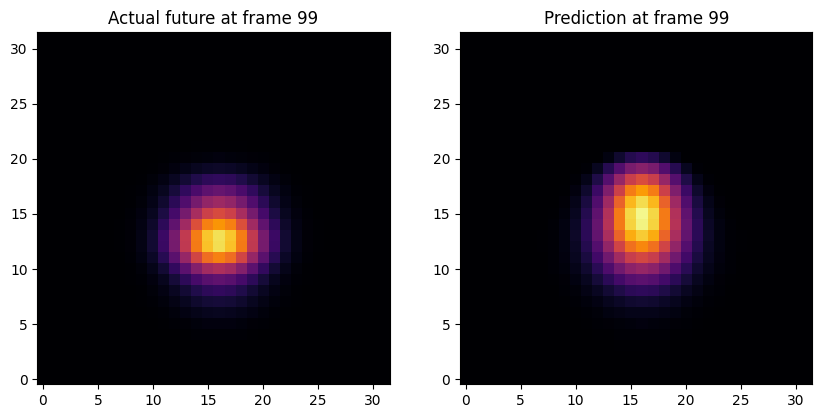

In [6]:
import matplotlib.pyplot as plt
from matplotlib import animation

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes

TEST_DATA = TEST_DATA.reshape(HORIZON, N, N)
denormalized_prediction.dependent_variable = denormalized_prediction.dependent_variable.reshape(HORIZON, N, N)

actual_density_i = TEST_DATA[0]
predicted_density_i = denormalized_prediction.dependent_variable[0]

im1 = ax1.imshow(actual_density_i, cmap='inferno', origin='lower', vmin=0, vmax=np.max(actual_density_i))
im2 = ax2.imshow(predicted_density_i, cmap='inferno', origin='lower', vmin=0, vmax=np.max(predicted_density_i))

def update(frame):
    actual_density = TEST_DATA[frame]
    predicted_density = denormalized_prediction.dependent_variable[frame]
    im1.set_data(actual_density)
    im2.set_data(predicted_density)
    ax1.set_title(f'Actual future at frame {frame}')
    ax2.set_title(f'Prediction at frame {frame}')
    return im1, im2

ani = animation.FuncAnimation(fig, update, frames=HORIZON, interval=50, blit=True)
ani.save('predicted_evolution.mp4', fps=30, dpi=150)